
## Capstone: Airbnb Price Predictions (Singapore)


### Contents:
- [Data Import](#Data-Import)
- [Preprocessing](#Preprocessing)
    + [Train Test Split Data](#Train-Test-Split-Data)
- [Modeling](#Modeling)
    + [Model 1: Linear Regression](#Model-1:-Linear-Regression)
    + [Model 2: Neural Network](#Model-2:-Neural-Network)
    + [Model 3: XGBoost](#Model-3:-XGBoost)
- [Summary and Recommendations](#Summary-and-Recommendations)

In [1]:
# imports:

#maths
import pandas as pd
import numpy as np
import scipy.stats as stats

#visual
import seaborn as sns
import matplotlib.pyplot as plt

#modelling
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error


from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt

from IPython.display import SVG
#!pip3 install xgboost
from xgboost import XGBRegressor
import xgboost as xgb
import time
from xgboost import plot_importance

%matplotlib inline

#To visualize the whole grid
pd.options.display.max_columns = 999

plt.style.use('fivethirtyeight')

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.


## Data Import
#### Read Cleaned Airbnb Singapore datasets

In [2]:
airbnb_df = pd.read_csv('../data/listings_cleaned.csv')

In [3]:
airbnb_df.head()

,id,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_90,instant_bookable,cancellation_policy,host_active,phone,email,id_verification,review,photo,socials,others,air_con,wifi,washer,essentials,kitchen,hangers,iron,tv,hair_dryer,shampoo,laptop_workspace,elevator,dryer,hot_water,bedroom_lock,pool,refrigerator,long_term_stays,gym,microwave,bedrooms_per_accommodates
0,49091,0,2,0,Woodlands,North Region,1.44255,103.79580,1,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,4.430817,0.0,0.0,1,14.0,180,90,0,flexible,3417.0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1.000000
1,50646,0,1,0,Bukit Timah,Central Region,1.33235,103.78521,1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,4.382027,0.0,0.0,2,20.0,90,90,0,moderate,3459.0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0.500000
2,56334,0,2,0,Woodlands,North Region,1.44246,103.79667,1,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,4.248495,0.0,0.0,1,14.0,6,90,0,flexible,3417.0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1.000000
3,71609,0,8,1,Tampines,East Region,1.34541,103.95712,1,Other,Private room,6,1.0,2.0,3.0,Real Bed,5.332719,279.0,56.0,4,28.0,1,90,1,flexible,3316.0,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,0,0,0.333333
4,71896,0,8,1,Tampines,East Region,1.34567,103.95963,1,House,Private room,3,0.5,1.0,1.0,Real Bed,4.553877,140.0,28.0,1,21.0,1,90,1,moderate,3316.0,1,1,0,1,0,0,1,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0.333333


## Preprocessing

Get dummy variables for categorical features.

In [4]:
airbnb_df_dum = pd.get_dummies(airbnb_df)

In [5]:
airbnb_df_dum

,id,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_90,instant_bookable,host_active,phone,email,id_verification,review,photo,socials,others,air_con,wifi,washer,essentials,kitchen,hangers,iron,tv,hair_dryer,shampoo,laptop_workspace,elevator,dryer,hot_water,bedroom_lock,pool,refrigerator,long_term_stays,gym,microwave,bedrooms_per_accommodates,neighbourhood_cleansed_Ang Mo Kio,neighbourhood_cleansed_Bedok,neighbourhood_cleansed_Bishan,neighbourhood_cleansed_Bukit Batok,neighbourhood_cleansed_Bukit Merah,neighbourhood_cleansed_Bukit Panjang,neighbourhood_cleansed_Bukit Timah,neighbourhood_cleansed_Central Water Catchment,neighbourhood_cleansed_Choa Chu Kang,neighbourhood_cleansed_Clementi,neighbourhood_cleansed_Downtown Core,neighbourhood_cleansed_Geylang,neighbourhood_cleansed_Hougang,neighbourhood_cleansed_Jurong East,neighbourhood_cleansed_Jurong West,neighbourhood_cleansed_Kallang,neighbourhood_cleansed_Lim Chu Kang,neighbourhood_cleansed_Mandai,neighbourhood_cleansed_Marina South,neighbourhood_cleansed_Marine Parade,neighbourhood_cleansed_Museum,neighbourhood_cleansed_Newton,neighbourhood_cleansed_Novena,neighbourhood_cleansed_Orchard,neighbourhood_cleansed_Outram,neighbourhood_cleansed_Pasir Ris,neighbourhood_cleansed_Pioneer,neighbourhood_cleansed_Punggol,neighbourhood_cleansed_Queenstown,neighbourhood_cleansed_River Valley,neighbourhood_cleansed_Rochor,neighbourhood_cleansed_Sembawang,neighbourhood_cleansed_Sengkang,neighbourhood_cleansed_Serangoon,neighbourhood_cleansed_Singapore River,neighbourhood_cleansed_Southern Islands,neighbourhood_cleansed_Sungei Kadut,neighbourhood_cleansed_Tampines,neighbourhood_cleansed_Tanglin,neighbourhood_cleansed_Toa Payoh,neighbourhood_cleansed_Western Water Catchment,neighbourhood_cleansed_Woodlands,neighbourhood_cleansed_Yishun,neighbourhood_group_cleansed_Central Region,neighbourhood_group_cleansed_East Region,neighbourhood_group_cleansed_North Region,neighbourhood_group_cleansed_North-East Region,neighbourhood_group_cleansed_West Region,property_type_Apartment,property_type_Boutique hotel,property_type_Bungalow,property_type_Condominium,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Townhouse,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,49091,0,2,0,1.442550,103.795800,1,1,1.0,1.0,1.0,4.430817,0.0,0.0,1,14.0,180,90,0,3417.0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
1,50646,0,1,0,1.332350,103.785210,1,2,1.0,1.0,1.0,4.382027,0.0,0.0,2,20.0,90,90,0,3459.0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0.500000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
2,56334,0,2,0,1.442460,103.796670,1,1,1.0,1.0,1.0,4.248495,0.0,0.0,1,14.0,6,90,0,3417.0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
3,71609,0,8,1,1.345410,103.957120,1,6,1.0,2.0,3.0,5.332719,279.0,56.0,4,28.0,1,90,1,3316.0,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,0,0,0.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0

### Train Test Split Data

In [6]:
# Separating X and y
X = airbnb_df_dum.drop('price', axis=1)
y = airbnb_df_dum.price

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    random_state=42)
# Scaling
ss = StandardScaler()
X_ss_train = ss.fit_transform(X_train)
X_ss_test = ss.transform(X_test)

In [7]:
y.mean()

4.759086024481349

In [8]:
n_inputs = X_ss_train.shape[1]
n_inputs

120

## Modeling

### Model 1: Linear Regression

To evaluate LinearRegression and LassoCV, so we'll need to create instances of all three models.

In [9]:
# instantiate the 2 models:

lr = LinearRegression()
lasso = LassoCV(n_alphas = 500, verbose = 0)

#### Linear Regression

Use cross_val_score to evaluate the two models and select the one that would give the highest R2 score.

In [10]:
# cross validation for linear regression

lr_score = cross_val_score(lr, X_ss_train, y_train, cv = 10)
print(f' The R2 score for LinearRegression is {round(lr_score.mean(), 4)}')

 The R2 score for LinearRegression is -1.6666235911547796e+25


The mean R2 is extremely negative. It is probably overfitting and the redundant features are affecting the coefficients.

#### Lasso

In [11]:
# cross validation for lasso

lasso_score = cross_val_score(lasso, X_ss_train, y_train, cv = 10)
print(f' The R2 score for Lasso is {round(lasso_score.mean(), 4)}')

 The R2 score for Lasso is 0.6558


The mean R2 score for Lasso is **much better** than Linear Regression. This is expected as Lasso is able to help in **feature selection**, eleminating those insignificant features (by zero-ing out the coefficients). It is also able to **manage multicollinearity**.

In [12]:
# finding an optimal value for Lasso regression alpha using LassoCV

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=0)
optimal_lasso.fit(X_ss_train, y_train)

print (f'Optimal lasso alpha : {optimal_lasso.alpha_}')

Optimal lasso alpha : 0.0049980397607677475


In [13]:
# cross validation the optimal lasso alpha with R2

lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_score = cross_val_score(lasso, X_ss_train, y_train, cv=10)
print (f'Lasso R2 score: {lasso_score}')
print (f'Lasso R2 score (mean): {round(np.mean(lasso_score), 4)}')

Lasso R2 score: [0.67033792 0.64011027 0.68179159 0.64085713 0.67024211 0.62012195
 0.64525643 0.66162248 0.6810816  0.64900774]
Lasso R2 score (mean): 0.656


In [14]:
# use the optimal alpha to fit into Lasso model

lasso.fit(X_ss_train, y_train)

Lasso(alpha=0.0049980397607677475, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [15]:
print(f'The R2 score for Lasso from training data: { round(lasso.score(X_ss_train, y_train), 4)}')
print(f'The R2 score for Lasso from test data: { round(lasso.score(X_ss_test, y_test), 4)}') 

The R2 score for Lasso from training data: 0.6732
The R2 score for Lasso from test data: 0.6643


In [16]:
# fitting the model with lasso

y_pred = lasso.predict(X_ss_test)

In [17]:
print(f'Number of feature retain by Lasso = {np.sum(lasso.coef_ != 0)}') 
print(f'Number of features zeroed out by Lasso = {np.sum(lasso.coef_ == 0)}')

Number of feature retain by Lasso = 78
Number of features zeroed out by Lasso = 42


In [18]:
lasso_coefs = pd.DataFrame({'features':X_train.columns,'lasso_coef':lasso.coef_})
lasso_coefs.head()

,features,lasso_coef
0,id,-0.000000
1,host_is_superhost,-0.000000
2,host_listings_count,0.005828
3,host_identity_verified,0.000000
4,latitude,-0.073971


In [19]:
lasso_coefs.sort_values('lasso_coef', inplace=True, ascending=False)

In [20]:
# extract the top 15 positive and top 5 negative coefficients to plot out

important_coefs = pd.concat([lasso_coefs.head(15), lasso_coefs.tail(5) ])

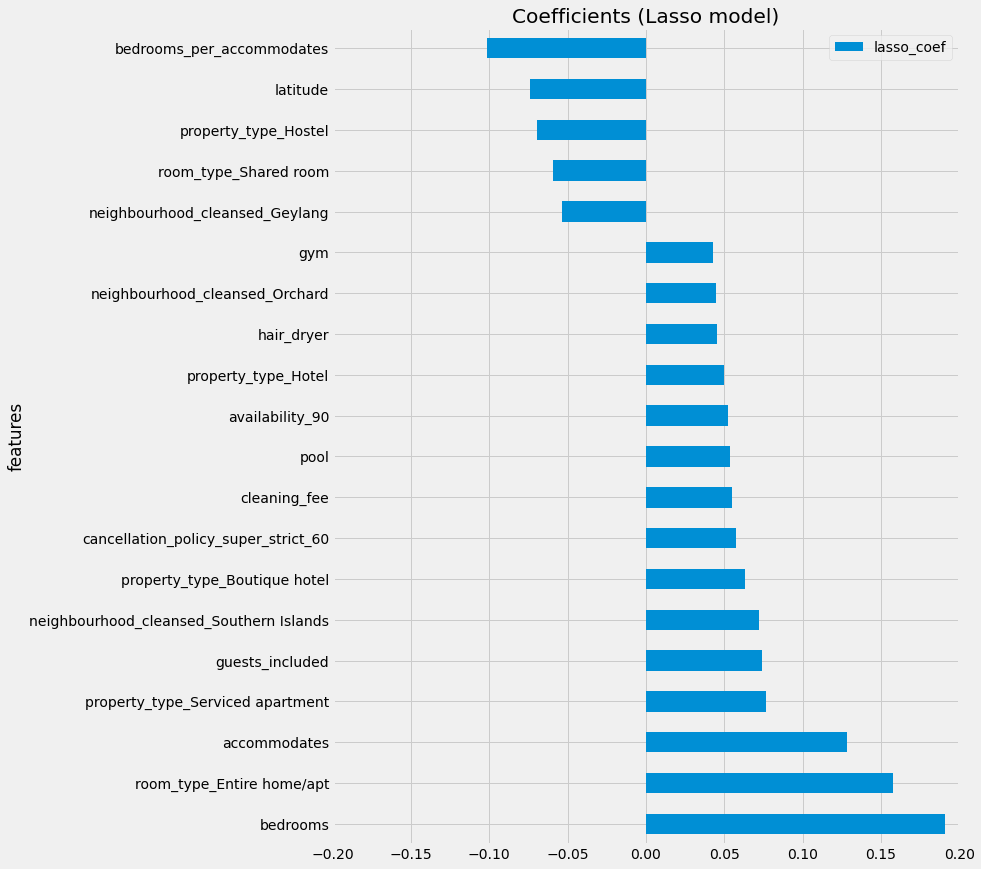

In [21]:
# Plot coefficients

plt.rcParams['figure.figsize'] = (10, 14)
important_coefs.plot(y = 'lasso_coef', x = 'features', kind = 'barh');
plt.title('Coefficients (Lasso model)');
plt.xlim(-0.20, 0.20);

### Model 2: Neural Network

The evaluation metrics used will be:
+ **mean squared error** (for loss)
+ **R2** (for accuracy)

#### Neural Network: Model 1

In [22]:
# Building the model
model = Sequential()

model.add(Dense(128, input_dim = n_inputs, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

# Compiling the model
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error','mae'])

history = model.fit(X_ss_train,
                    y_train,
                    validation_data=(X_ss_test, y_test),
                    epochs=100,
                    batch_size=256,
                    verbose=0)

# Model summary
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               15488     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 114,561
Trainable params: 114,561
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# MSE and R2 values

y_test_pred = model.predict(X_ss_test)
y_train_pred = model.predict(X_ss_train)
print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

Training MSE: 0.0051
Validation MSE: 0.2739

Training r2: 0.9915
Validation r2: 0.5123


#### Neural Network: Model 2 (with regularizations)

In [24]:
# Building the model
model_l2 = Sequential()

model_l2.add(Dense(128,
                input_dim = n_inputs, 
                activation = 'relu',
                kernel_regularizer = regularizers.l2(0.01)))
model_l2.add(Dropout(0.2))
model_l2.add(Dense(256, 
                activation = 'relu', 
                kernel_regularizer = regularizers.l2(0.01)))
model_l2.add(Dropout(0.2))
model_l2.add(Dense(256, 
                activation = 'relu',
                kernel_regularizer = regularizers.l2(0.01)))
model_l2.add(Dropout(0.2))
model_l2.add(Dense(1, 
                activation = 'linear',
                kernel_regularizer = regularizers.l2(0.01)))



# Compiling the model
model_l2.compile(loss='mean_squared_error',
                 optimizer='adam',
              metrics=['mean_squared_error','mae'])

early_stop = EarlyStopping(monitor = 'val_mean_squared_error', 
                           min_delta = 0, 
                           patience = 0)

history_l2 = model_l2.fit(X_ss_train,
                          y_train,
                          validation_data=(X_ss_test, y_test),
                          epochs=100,
                          batch_size=256,
                          verbose=0)

# Model summary
print(model_l2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               15488     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [25]:
# MSE and R2 values

y_test_pred = model_l2.predict(X_ss_test)
y_train_pred = model_l2.predict(X_ss_train)
print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

Training MSE: 0.0897
Validation MSE: 0.1555

Training r2: 0.8494
Validation r2: 0.7231


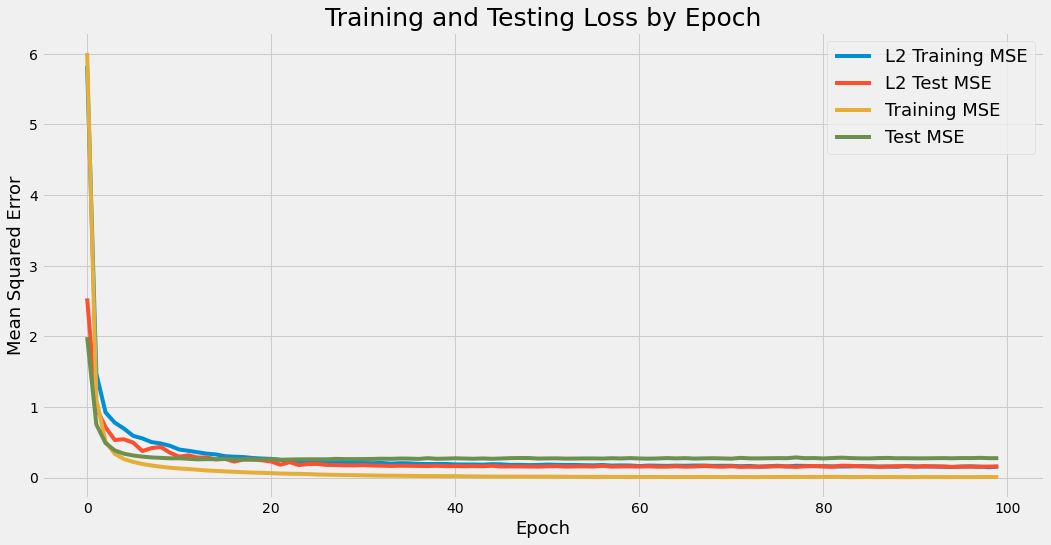

In [26]:
# Check out our train loss and test loss over epochs.
# Set figure size.
plt.figure(figsize=(16, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(history_l2.history['mean_squared_error'], label = 'L2 Training MSE')
plt.plot(history_l2.history['val_mean_squared_error'], label = 'L2 Test MSE')


plt.plot(history.history['mean_squared_error'], label = 'Training MSE')
plt.plot(history.history['val_mean_squared_error'], label = 'Test MSE')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Mean Squared Error', fontsize = 18)

plt.legend(fontsize = 18);

### Model 3: XGBoost

In [27]:
# xgboost

xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_ss_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_ss_train)
val_preds_xgb_reg = xgb_reg.predict(X_ss_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.1 minutes

Training MSE: 0.0189
Validation MSE: 0.1324

Training r2: 0.9684
Validation r2: 0.7642


With a **high training accuracy score**, and a **low test accuracy**, it shows that there have been an **overfit** and thus we will use RandomSearchCV to help in our parameter tuning.

In [28]:
# xgboost with parameter tuning

xgb_reg = xgb.XGBRegressor()

param_grid = {'silent': [False],
              'max_depth': [7,8,9,10],
              'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
              'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
              'gamma': [0, 0.25, 0.5, 1.0],
              'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
              'n_estimators': [100]}

rs = RandomizedSearchCV(xgb_reg,
                        param_grid,
                        n_iter=20,
                        n_jobs=1,
                        verbose=0,
                        cv=2,
                        random_state=42)

print("Randomized search..")
search_time_start = time.time()
rs.fit(X_ss_train, y_train)
training_preds_xgb_rs = rs.predict(X_ss_train)
val_preds_xgb_rs = rs.predict(X_ss_test)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs.best_score_
best_params = rs.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Randomized search time: 36.19138813018799
Best score: 0.7466437449419683
Best params: 
colsample_bylevel: 1.0
colsample_bytree: 0.5
gamma: 0.25
learning_rate: 0.1
max_depth: 9
min_child_weight: 7.0
n_estimators: 100
reg_lambda: 10.0
silent: False
subsample: 1.0


In [29]:
xgb_reg_start = time.time()

xgb_rs = xgb.XGBRegressor(colsample_bylevel = 1.0,
                           colsample_bytree = 0.5,
                           gamma = 0.25,
                           learning_rate = 0.1,
                           max_depth = 9,
                           min_child_weight = 7.0,
                           n_estimators = 100 ,
                           reg_lambda = 10.0,
                           silent = False,
                           subsample = 1.0)

xgb_rs.fit(X_ss_train, y_train)
training_preds_xgb_rs = xgb_rs.predict(X_ss_train)
val_preds_xgb_rs = xgb_rs.predict(X_ss_test)

In [30]:
print("XGBRegressor RS")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_rs),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_rs),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_rs),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_rs),4))

XGBRegressor RS

Training MSE: 0.0674
Validation MSE: 0.1222

Training r2: 0.8868
Validation r2: 0.7825


In [31]:
ft_weights_xgb_rs = pd.DataFrame(xgb_rs.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_rs.sort_values('weight', inplace=True)
ft_weights_xgb_rs

,weight
neighbourhood_cleansed_Serangoon,0.000000
neighbourhood_cleansed_Central Water Catchment,0.000000
neighbourhood_cleansed_Lim Chu Kang,0.000000
neighbourhood_cleansed_Mandai,0.000000
neighbourhood_cleansed_Ang Mo Kio,0.000000
...,...
property_type_Serviced apartment,0.033872
accommodates,0.051826
tv,0.069908
bedrooms,0.173050


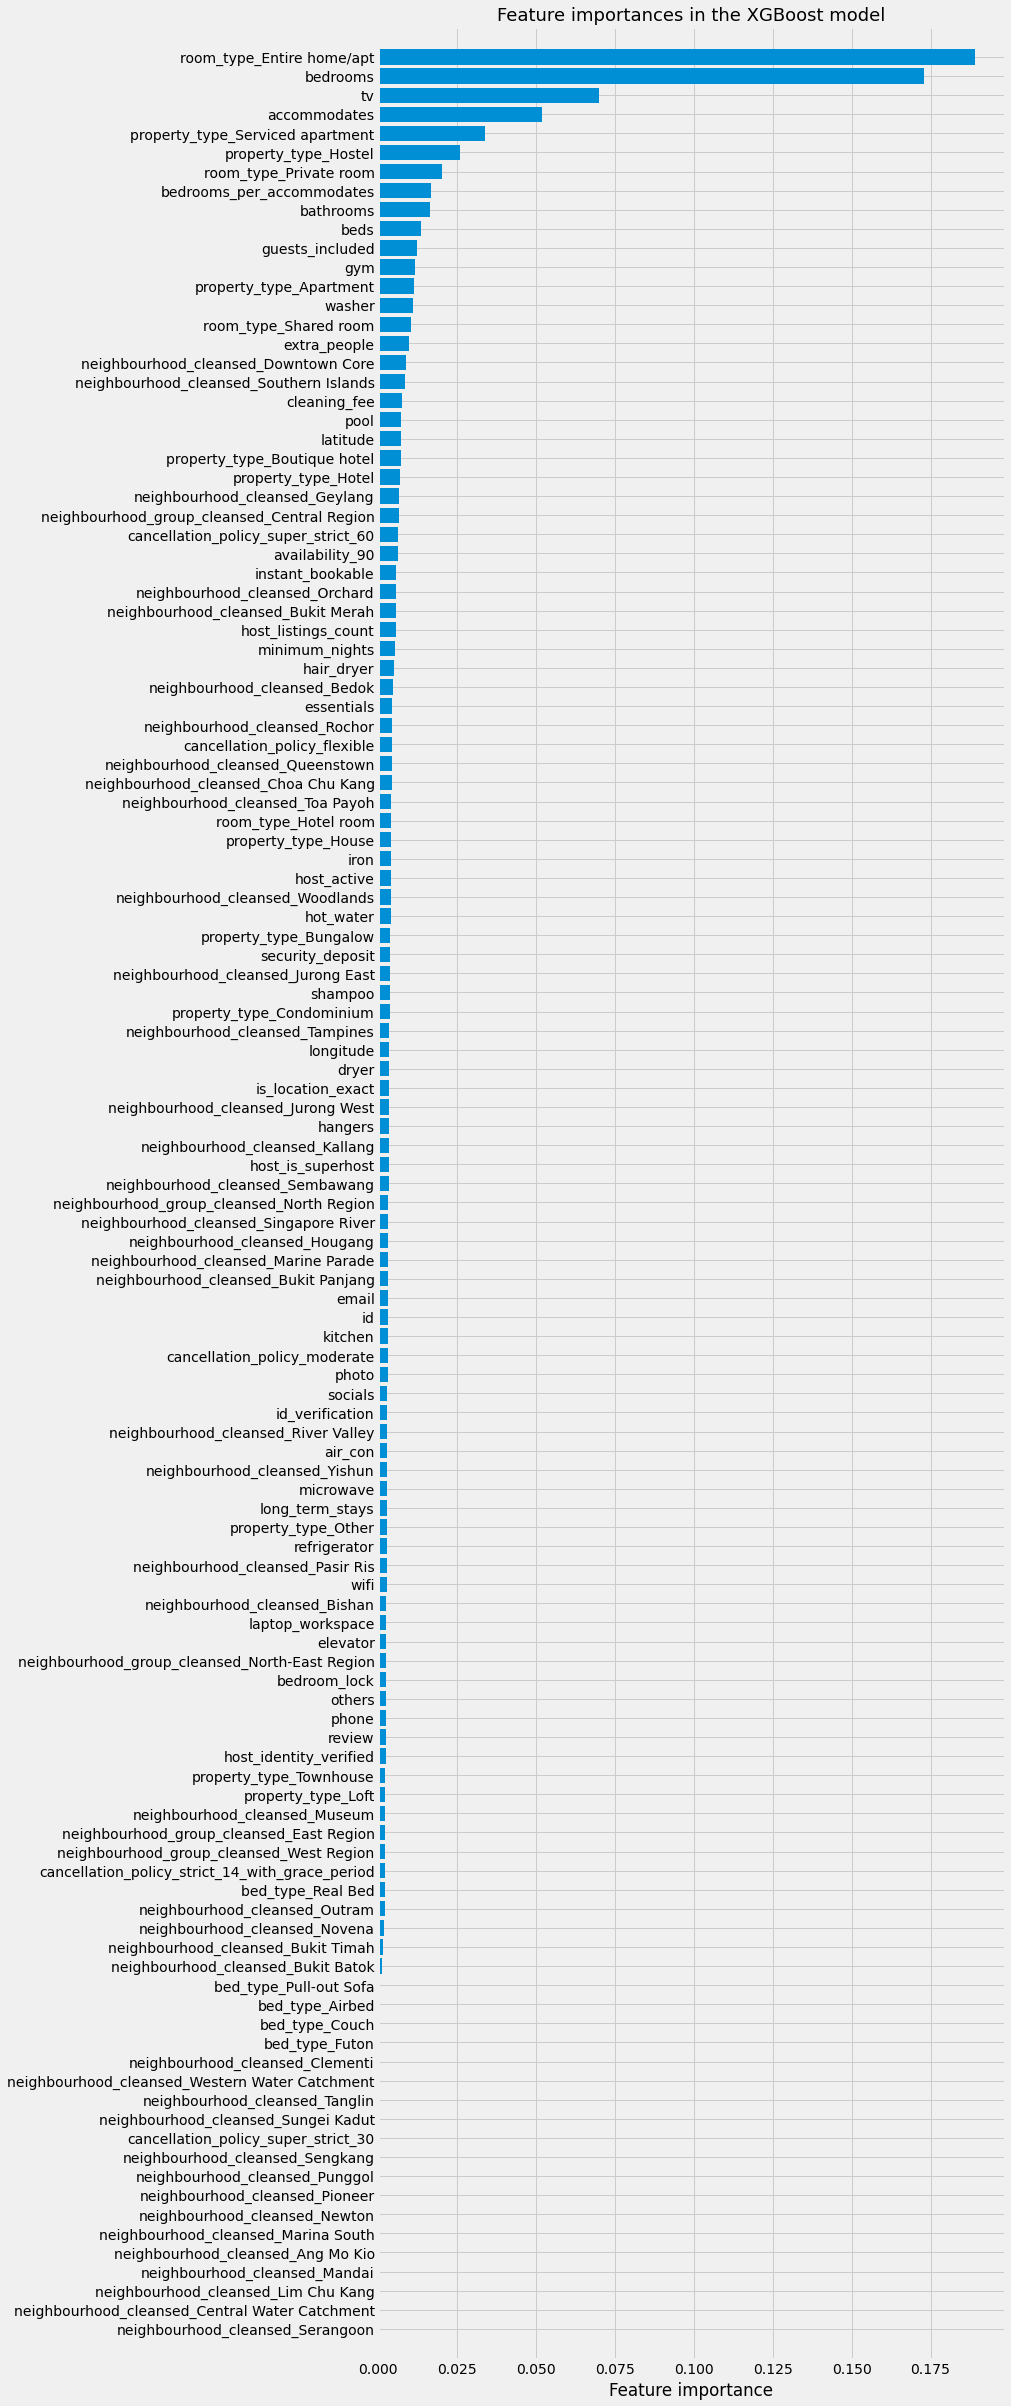

In [32]:
# plotting feature importances
plt.rcParams['figure.figsize'] = (10, 40)
plt.barh(ft_weights_xgb_rs.index, ft_weights_xgb_rs.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=18)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

**The top 10 most important features are:**

+ Room type: Entire home/apt
+ Number of Bedrooms
+ TV
+ Number of Accommodates
+ Property type: Serviced apartment
+ Property type: Hostel
+ Room type: Private room
+ Bedrooms per accommodates
+ Number of Bathrooms
+ Number of Beds

The most important feature is what type of room it is classified as, where entire home/apt would fetch a higher price as compared to a hotel/private/shared room. The presence of a TV and the number of bedrooms an apartment has are also understandably important features that one would certainly consider when deciding for an apartment to book.

The top 10 features do make sense as they are all features to consider when one is comparing between apartments.

In [33]:
airbnb_df_dum['unlog_price'] = np.exp(airbnb_df_dum.price)

In [34]:
airbnb_df_dum.to_csv('../data/listings_flask.csv', index = False)

## Summary and Recommendations

### Summary

#### Top 5 features with impact to the listing price for Airbnb Singapore
The room type being an **entire home/apartment** top the list as the most significant value added feature to the listing price. The number of bedrooms and whether the place comes with a TV also value added to the listing price. The number of accomodates the listing is able to hold is also one of the key factor that adds value to the listing price.

#### Neighborhoods with positive impact to listing price

Downtown Core, Southern Islands and Geylang are the 3 neighborhoods that potentially have positive impact to listing prices.

### Recommendation

The room type in this case is the key to the listing price, as it seems that listing the place as a entire home/apartment as compared to a hotel, private or shared room would be priced higher. Based on the model, taking note of the number of bathrooms, beds and bedrooms a listing has would also improve the value of the place. Another factor that should not be neglected is the general zoning of the listings as well. Listings tend to have a higher value located at the central regions.

### Conclusion

The model is generally able to predict well the listing price in Singapore. However, it would require some changes if it were to be applied to other countries as there are quite a number of influencing factors that are unique to Singapore. This would include, the neighbourhood, etc. Furthermore, the baseline housing price per night in other cities maybe priced differently from Singapore. Instead of revising the model, new dataset on the other city is needed to do the modeling, but could consider using the similar approach learn here.